In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pathlib
from pathlib import Path 
from tqdm import tqdm 
import pandas as pd
import os
import torch
import scipy



import warnings
warnings.filterwarnings("ignore")

In [2]:
from ReadImageBin  import ImageBin,rescale_transform

In [3]:
def sort_txt_bin(path):
    """
    input:path is a string, which is the directory of the files (image bins and txt)
    :return:image_bin: a list containing name of all image bins  ( not directory included)
         txt: a list containing name of all txt names
    """
    all_file=os.listdir(path)  ## return the names of all files, collected in a list
    image_bin=[]
    txt=[]
    for filename in all_file:
        if filename.endswith('.txt'):
            txt.append(filename)
        elif filename.endswith('.bin') :
            image_bin.append(filename)
        else: continue   
     
    
    return image_bin,txt



def findtxt(target,scope):
    """ this is to do the string match, match:
        target: the patient number you want to find, should be a string , such as N152934550
        scope: the txt list you want to find in this scope 
        
        return:name of matched txt, should be a string
         if not found, return ValueError
    """
    count=0
    for txt in scope:
        pos=txt.find(target)
        if pos==0:
            return scope[count]
        else: count+=1

    raise ValueError('You did not setup the right scope or target')

def pair_bin_txt(path):
    """
    Purpose:
       this is to make pair of image.bin file and .txt, because not all the files are paired, so this function act as filter to select the data could be utilized.
    Args:
       image_bin: a list which contains all the image_bin names
       txt: a list which contains all the txt file names.
   return :
       paired image_bin, paired txt. patients name
    
    """
    image_bin,txt=sort_txt_bin(path)
    ## patients_bin ans_d patients_txt are lists for patients number, containing  N152934550 etc.
    patients_bin=[]
    patients_txt=[]
    ##form: ['N152934550.image.bin'.....##
    for patient in image_bin:
        patient_trun=patient.split('.')
        patients_bin.append(patient_trun[0])
    ##form : ['N152934550_2020.11.16_anon.txt'.....]##
    for patient in txt:
        patient_trun=patient.split('_')
        patients_txt.append(patient_trun[0])
        
    ##convert to set and find intersection of two sets
    bin_set=set(patients_bin)
    txt_set=set(patients_txt)
    bin_txt_set=bin_set.intersection(txt_set)
    
    ## bin set and txt file
    final_bin=[]
    final_txt=[]
    patients_name=list(bin_txt_set)  ## intersection
    
    for patient in patients_name:
        #first concatenate  image.bin
        patient_bin=patient+'.'+'image'+'.'+'bin'
        final_bin.append(patient_bin)
        
        ## concatenate  txt:
        patient_txt=findtxt(patient,txt)
        final_txt.append(patient_txt)
    
    return final_bin, final_txt,patients_name

In [4]:
def extract_info(raw_datadir,transform=True):
    raw_datadir=Path(raw_datadir).resolve()
    pat_bin,pat_txt,patients_name=pair_bin_txt(raw_datadir)
    info=[]
    for i in range(len(pat_txt)):
        txt_df=pd.read_csv(raw_datadir/"{}".format(pat_txt[i]),sep=" :=",index_col=0,header=None)
        
        SRD_STRESS_DIST=float(txt_df.loc["SRD_STRESS_DIST(03)"])
        SRD_REST_DIST=float(txt_df.loc["SRD_REST_DIST(03)"])
        
        CTR_VOLUMES_stress=float(txt_df.loc["CTR_VOLUMES(00)"])
        CTR_VOLUMES_rest=float(txt_df.loc["CTR_VOLUMES(01)"])
        ENDO_VOLUMES_stress=float(txt_df.loc["ENDO_VOLUMES(00)"])
        ENDO_VOLUMES_rest=float(txt_df.loc["ENDO_VOLUMES(01)"])
        TID=float(txt_df.loc["TID_INDEX"])
        sr_ratio=float(txt_df.loc["SCAN_DETAILS_1(05)"])
        
        info.append([CTR_VOLUMES_stress,CTR_VOLUMES_rest,ENDO_VOLUMES_stress,ENDO_VOLUMES_rest,TID,sr_ratio,SRD_STRESS_DIST,SRD_REST_DIST])
    info=np.asarray(info)
    colume=['CTR_VOLUMES_stress','CTR_VOLUMES_rest','ENDO_VOLUMES_stress','ENDO_VOLUMES_rest','TID','sr_ratio','SRD_STRESS_DIST','SRD_REST_DIST']
    return info,patients_name,colume
    

In [7]:
def extract_TID(raw_datadir,transform=True):
    raw_datadir=Path(raw_datadir).resolve()
    pat_bin,pat_txt,patients_name=pair_bin_txt(raw_datadir)
    info=[]
    for i in range(len(pat_txt)):
        txt_df=pd.read_csv(raw_datadir/"{}".format(pat_txt[i]),sep=" :=",index_col=0,header=None)
        
        SRD_STRESS_DIST=float(txt_df.loc["SRD_STRESS_DIST(03)"])
        SRD_REST_DIST=float(txt_df.loc["SRD_REST_DIST(03)"])
        age=np.int16(2022-float(txt_df.loc["DOB_YEAR"]))
        

        TID=float(txt_df.loc["TID_INDEX"])
        sr_ratio=float(txt_df.loc["SCAN_DETAILS_1(05)"])
        
        info.append([TID,sr_ratio,age,SRD_STRESS_DIST,SRD_REST_DIST])
    info=np.asarray(info)
    colume=['TID','Pseudo flow increase index','Age','SRD_STRESS_DIST','SRD_REST_DIST']
    return info,patients_name,colume

## Why transfer learning does not work

In [8]:
pat_mat,patients_name,colume=extract_TID('DUMP')

In [9]:
condition_nomral=pat_mat[:,3]>=73

normal_pat=pat_mat[condition_nomral,:]
abnormal_pat=pat_mat[np.logical_not(condition_nomral),:]
print(normal_pat.shape)
print(abnormal_pat.shape)

(174, 5)
(60, 5)


In [10]:
import scipy
from scipy.stats import shapiro,ttest_ind,mannwhitneyu
# from scipy.stats import ttest_ind
def statistical_test(f1,f2,i):
    """f1 is normal feature 
    f2 is abnormal feature
    i is the feature name
    """
    ## the purpose is to see whether the array are following Gaussian, if not should do Mann-Whitney U test
    print("Shapiro-Wilk test for two feature arrays,to see whether they are gaussian distributed")
    print("if p<0.05, we reject this is gaussian distributed")
    print("Normal group {} p-value is {:.4g} ".format(i,shapiro(f1)[1]))
    print("Abnormal group {} p-value is {:.4g} ".format(i,shapiro(f2)[1]))
    
    print("   t-test , suppose variance not same ,so perform Welch's t-test ")
    t_statistic,t_pvalue=ttest_ind(f1,f2,equal_var=False)
    print("t-statistic is {}, p-value is {:.4g}".format(t_statistic,t_pvalue))
    
    print("   Mann-Whitney U test , precondition is that they are not gaussian distributed")
    u_stat,u_pvalue=mannwhitneyu(f1,f2)  ## pay attention to alternative {‘two-sided’, ‘less’, ‘greater}
    print("u_statistic is {}, p-value is {:.4g}".format(u_stat,u_pvalue))
    return t_pvalue,t_pvalue

In [23]:
def violin_box_plot(f1,f2,i):
    data=[f1,f2]
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(6,4))

    axs[0].violinplot(data)
    axs[0].set_title('Violin plot')

    axs[1].boxplot(data)
    axs[1].set_title('Box plot')

    for ax in axs:
        ax.yaxis.grid(True)
        ax.set_xticks([1,2],labels=['Normal ','Abnormal'])
        ax.set_xlabel('{}'.format(i))
        ax.set_ylabel('Value')
        
#     fig.savefig('violin_box/{}.png'.format(i))
    plt.tight_layout()
    t_p,u_p=statistical_test(f1,f2,i)
    plt.show()
    fig.savefig('violin_box/{}.png'.format(i))

In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Shapiro-Wilk test for two feature arrays,to see whether they are gaussian distributed
if p<0.05, we reject this is gaussian distributed
Normal group TID p-value is 0.0001463 
Abnormal group TID p-value is 0.002613 
   t-test , suppose variance not same ,so perform Welch's t-test 
t-statistic is -2.6872135367811825, p-value is 0.008609
   Mann-Whitney U test , precondition is that they are not gaussian distributed
u_statistic is 3847.0, p-value is 0.002402


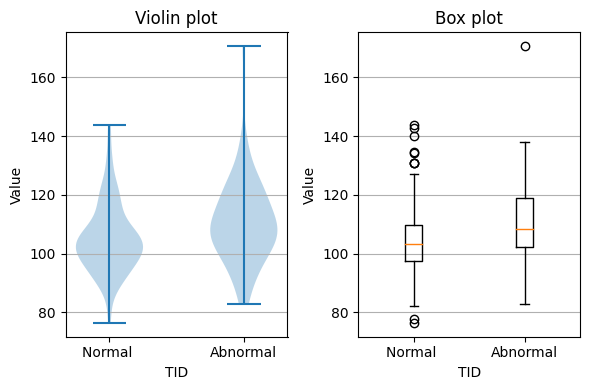

Shapiro-Wilk test for two feature arrays,to see whether they are gaussian distributed
if p<0.05, we reject this is gaussian distributed
Normal group Pseudo flow increase index p-value is 3.802e-08 
Abnormal group Pseudo flow increase index p-value is 0.0023 
   t-test , suppose variance not same ,so perform Welch's t-test 
t-statistic is 1.6931827907112913, p-value is 0.09281
   Mann-Whitney U test , precondition is that they are not gaussian distributed
u_statistic is 6052.5, p-value is 0.06576


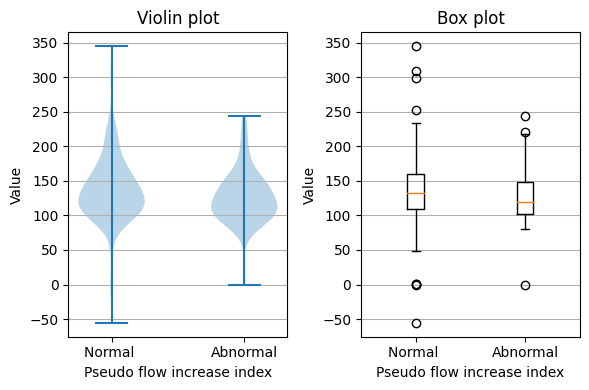

Shapiro-Wilk test for two feature arrays,to see whether they are gaussian distributed
if p<0.05, we reject this is gaussian distributed
Normal group Age p-value is 0.0001476 
Abnormal group Age p-value is 0.004036 
   t-test , suppose variance not same ,so perform Welch's t-test 
t-statistic is -1.2678765471601359, p-value is 0.2075
   Mann-Whitney U test , precondition is that they are not gaussian distributed
u_statistic is 4691.0, p-value is 0.2421


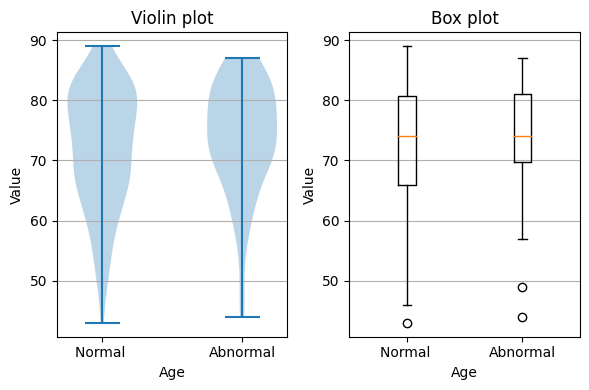

In [25]:
for i in range(len(colume)-2):
    violin_box_plot(normal_pat[:,i],abnormal_pat[:,i],colume[i])

In [18]:
import scipy
from scipy.stats import shapiro,ttest_ind,mannwhitneyu,linregress,pearsonr
def plot(c1,stress_dist,rest_dist,colume,num_bins=10):
    """c1 : colume ,such as TID"""
    _,p_shapiro=shapiro(c1)
    print("if p<0.05, we reject this is gaussian distributed")
    print(p_shapiro)
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,5))
    
    ## histogram of c1
    ax1.hist(c1,num_bins)
    ax1.set_xlabel('{}'.format(colume))
    ax1.set_ylabel("counts")
    ax1.set_title('Histogram of {} \n  p-value of shapiro test : {:.4g}'.format(colume,p_shapiro))
    ax1.axvline(x=np.mean(c1),ymax=np.max(c1),color='red',linestyle='--',label='Mean Value {}'.format(np.mean(c1)))
    ax1.axvline(x=np.median(c1),ymax=np.max(c1),color='black',linestyle='--',label='Median Value {}'.format(np.median(c1)))
    ax1.legend()
    r_stress,p_value=pearsonr(c1,stress_dist)
    r_rest,p_rest=pearsonr(c1,rest_dist)
    print("Pearson test  between normal stress distribution  (Confidence_level = 0.95) : ")
    print("pearson r: {} and p-value: {}".format( r_stress,p_value) )
    print("Pearson test  between normal rest distribution  (Confidence_level = 0.95) : ")
    print("pearson r: {} and p-value: {}".format( r_rest,p_rest))    
    
    ##c1 against stress_dist

    ax2.set_xlabel('Normal extent in stress polarmap')
    ax2.set_ylabel('{}'.format(colume))
    ax2.set_title('{} against normal stress extent \n'.format(colume)+"pearson r: {:.4g} and p-value: {:.4g}".format( r_stress,p_value))
    ax2.scatter(stress_dist,c1,c='green')
    
    ## c1 against  rest_dist

    ax3.set_xlabel('Normal extent in rest polarmap')
    ax3.set_ylabel('{}'.format(colume))
    ax3.set_title('{} against normal rest extent \n'.format(colume)+"pearson r: {:.4g} and p-value: {:.4g}".format( r_rest,p_rest))
    ax3.scatter(rest_dist,c1,c='green')

    
    f.tight_layout()
    plt.savefig('{}'.format(colume))
    

    plt.show()

if p<0.05, we reject this is gaussian distributed
1.3509901464203722e-06
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.22530919517210124 and p-value: 0.0005149193475652576
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.17123195476023717 and p-value: 0.008671715360930733


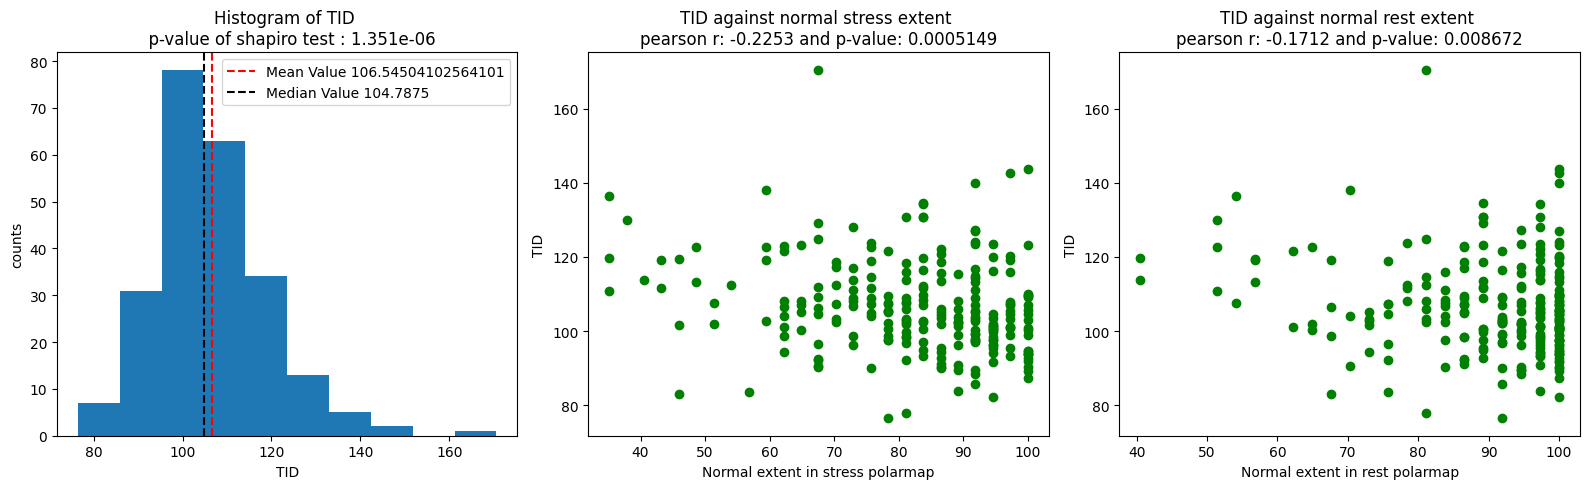

if p<0.05, we reject this is gaussian distributed
7.220450348732754e-10
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: 0.18461499639409362 and p-value: 0.004606457212189726
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: 0.08752314789849748 and p-value: 0.18212556545979566


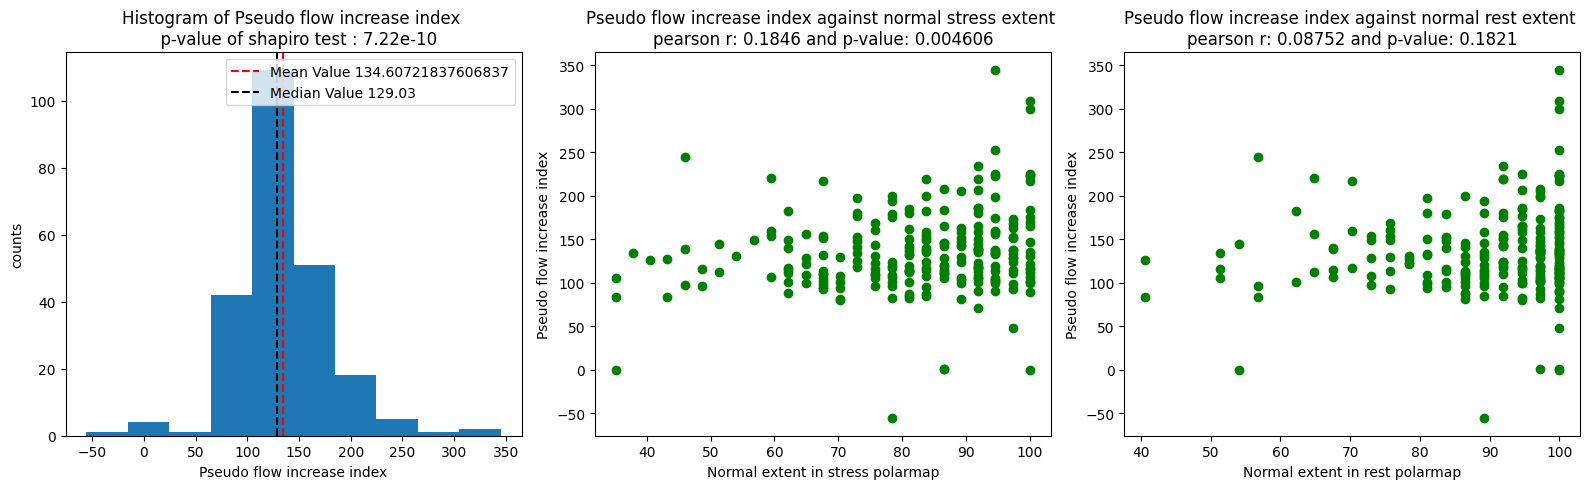

if p<0.05, we reject this is gaussian distributed
3.6142323551757727e-06
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.02629294884894587 and p-value: 0.6890680334866087
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.05658445019242953 and p-value: 0.3888905957092518


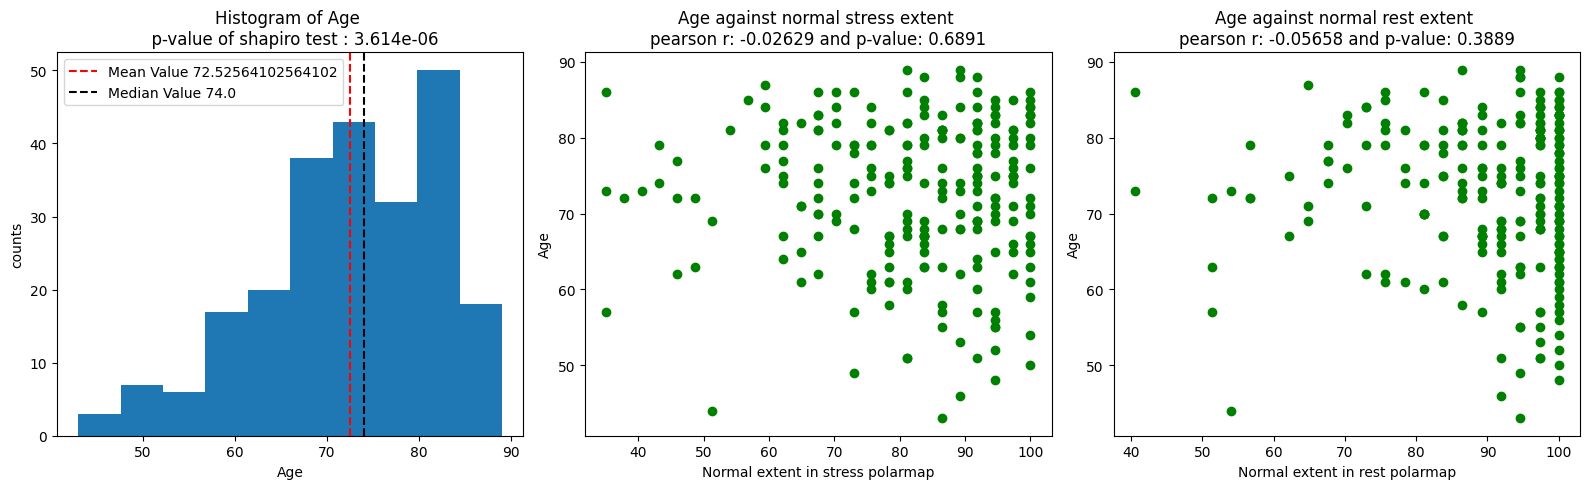

In [19]:
for i in range(len(colume)-2):
    plot(pat_mat[:,i],pat_mat[:,-2],pat_mat[:,-1],colume[i])

##  Threshold  (old code)

In [31]:
l_bin,ltxt=sort_txt_bin('DUMP')
print("number of image bin is " , len(l_bin))
print("number of txt is " , len(ltxt))

number of image bin is  267
number of txt is  237


In [32]:
pat_mat,patients_name,colume=extract_info('DUMP')

In [33]:
print(patients_name)
print(colume)
print(pat_mat.shape)

['N183705422', 'N153769053', 'N181488089', 'N179253184', 'N151767359', 'N185723201', 'N184444250', 'N154231861', 'N186198639', 'N182650517', 'N183151748', 'N181720921', 'N181782520', 'N182886554', 'N152977401', 'N184176732', 'N185434049', 'N181731508', 'N184181113', 'N182843148', 'N184734820', 'N184291640', 'N185621051', 'N181996749', 'N184330233', 'N185747295', 'N183924138', 'N184483815', 'N153628207', 'N182420606', 'N182899628', 'N184078604', 'N183315676', 'N153328533', 'N153217721', 'N183016575', 'N184607161', 'N152972697', 'N151959146', 'N184599359', 'N182819249', 'N185646387', 'N184961671', 'N183339375', 'N185446595', 'N186047663', 'N153550277', 'N181798638', 'N181977482', 'N184496853', 'N183697394', 'N183205277', 'N184726702', 'N185078988', 'N152934550', 'N183408689', 'N184444253', 'N184866589', 'N185477340', 'N182646844', 'N153015520', 'N184606184', 'N185646735', 'N154152815', 'N184920484', 'N177627328', 'N185420679', 'N184715289', 'N183887085', 'N153905848', 'N185326362', 'N185

In [34]:
stress_dist,rest_dist=pat_mat[:,-2],pat_mat[:,-1]
print(stress_dist)
print(rest_dist)

[ 97.2973  75.6757  64.8649  72.973   67.5676  81.0811  64.8649  91.8919
  78.3784  72.973  100.      78.3784  97.2973  91.8919  89.1892 100.
  94.5946 100.      45.9459  94.5946  89.1892 100.      75.6757  83.7838
 100.      75.6757  59.4595  83.7838  81.0811  81.0811  78.3784 100.
 100.      67.5676  83.7838  70.2703  37.8378  97.2973  81.0811  81.0811
  81.0811  91.8919  91.8919  86.4865  72.973   64.8649  97.2973  94.5946
  97.2973  81.0811  67.5676  94.5946  59.4595 100.      89.1892  35.1351
  97.2973 100.      91.8919  97.2973 100.      91.8919  62.1622  78.3784
  83.7838  86.4865  94.5946  70.2703  67.5676  70.2703  35.1351  70.2703
  72.973   78.3784  91.8919  86.4865  67.5676  89.1892 100.      67.5676
  91.8919  97.2973  94.5946  81.0811  67.5676  97.2973  91.8919  86.4865
  86.4865  97.2973  51.3513  81.0811 100.      91.8919  94.5946  91.8919
  62.1622  89.1892  91.8919  94.5946  94.5946  62.1622  91.8919  62.1622
  83.7838  62.1622  67.5676 100.      89.1892  81.0811 100.

In [35]:
print(np.median(stress_dist))
print(np.median(rest_dist))

83.7838
94.5946


In [36]:
print(stress_dist>rest_dist)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [37]:
sorted_stress=np.argsort(stress_dist)
print(sorted_stress)
print(stress_dist[sorted_stress])
sorted_rest=np.sort(rest_dist)
print(sorted_rest)
## 37 partition

[ 55  70 217  36 118 175 163 194 196  18 159 205 188  90 191 186 165  26
  52 128 218 141 131 105 103 101  62  96 199  45   6   2 221 210  50  84
  68 106  76 155  79 152   4 160  33  67 231  35 124  69  71 164 117 183
  72   9 157 223   3  44 168   1 177 227 215  22  25 143 142 158 179 147
 114 137 129 189 116   8 219  73  11  63  30 146  28  29 109 127  49 134
  38  39  40 111 182 145   5  83  91 200 203  64 123 121  34 220 206 169
 216 112 190 230 104  27 144 161 229  23 139 140 185  75 170 172 148 166
 167  88  43 207  65 178  87 209  77  20  14  97 213  54 226 174 195 119
 193 187 108   7 202 162 173  74  86 204 208  93  13  80  41 156 122 120
 192 222 138  58 102  61  98 184 150  42  95 225 228 224 180 198 233 125
  66 232  82  51 100  47 113  99  19  16 151 153 176 154  94  59  81  56
  48  46  37  12 212  85   0 132 136 115 135 130  89  10 181  15 149  17
  21  24  31  32  92 126  53 214  57 110 211 107  60 197  78 201 133 171]
[ 35.1351  35.1351  35.1351  37.8378  40.5405  43.

# For Frequency Analysis

## Normal:
### Stress threshold: 89
### rest threshold:90

## Abornal:
### Stress threshold: 71
### rest threshold:73  
rest :t  
72.9730  mildly abnormal   
75.6757  normal

In [38]:
import scipy
from scipy.stats import shapiro,ttest_ind,mannwhitneyu,linregress,pearsonr
def plot(c1,stress_dist,rest_dist,colume,num_bins=10):
    """c1 : colume ,such as TID"""
    _,p_shapiro=shapiro(c1)
    print("if p<0.05, we reject this is gaussian distributed")
    print(p_shapiro)
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,5))
    
    ## histogram of c1
    ax1.hist(c1,num_bins)
    ax1.set_xlabel('{}'.format(colume))
    ax1.set_ylabel("counts")
    ax1.set_title('Histogram of {} \n  p-value of shapiro test : {:.4g}'.format(colume,p_shapiro))
    ax1.axvline(x=np.mean(c1),ymax=np.max(c1),color='red',linestyle='--',label='Mean Value {}'.format(np.mean(c1)))
    ax1.axvline(x=np.median(c1),ymax=np.max(c1),color='black',linestyle='--',label='Median Value {}'.format(np.median(c1)))
    ax1.legend()
    r_stress,p_value=pearsonr(c1,stress_dist)
    r_rest,p_rest=pearsonr(c1,rest_dist)
    print("Pearson test  between normal stress distribution  (Confidence_level = 0.95) : ")
    print("pearson r: {} and p-value: {}".format( r_stress,p_value) )
    print("Pearson test  between normal rest distribution  (Confidence_level = 0.95) : ")
    print("pearson r: {} and p-value: {}".format( r_rest,p_rest))    
    
    ##c1 against stress_dist

    ax2.set_xlabel('Normal extent in stress polarmap')
    ax2.set_ylabel('{}'.format(colume))
    ax2.set_title('{} against stress extent \n'.format(colume)+"pearson r: {:.4g} and p-value: {:.4g}".format( r_stress,p_value))
    ax2.scatter(stress_dist,c1,c='green')
    
    ## c1 against  rest_dist

    ax3.set_xlabel('Normal extent in rest polarmap')
    ax3.set_ylabel('{}'.format(colume))
    ax3.set_title('{} against rest extent \n'.format(colume)+"pearson r: {:.4g} and p-value: {:.4g}".format( r_rest,p_rest))
    ax3.scatter(rest_dist,c1,c='green')

    
    f.tight_layout()
#     plt.savefig('{}'.format(colume))
    

    plt.show()
    

if p<0.05, we reject this is gaussian distributed
7.819369067171844e-14
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.4521288159098147 and p-value: 3.434127182318432e-13
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.4514956789714444 and p-value: 3.7378024281659997e-13


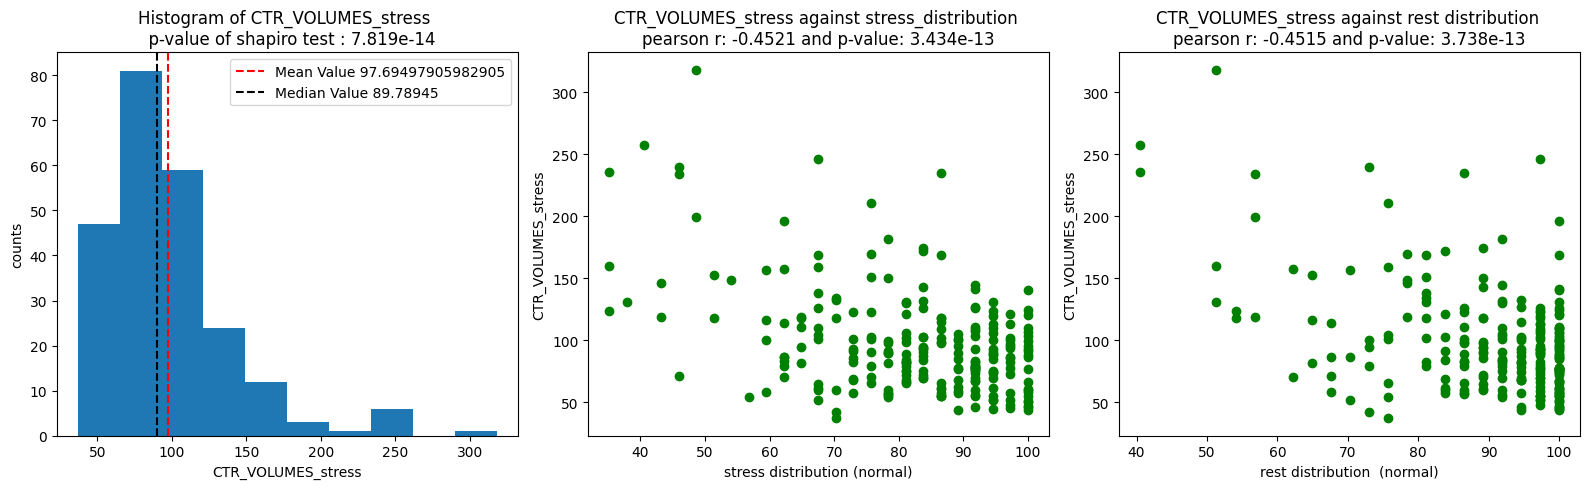

In [39]:
plot(pat_mat[:,0],pat_mat[:,-2],pat_mat[:,-1],colume=colume[0])

if p<0.05, we reject this is gaussian distributed
7.819369067171844e-14
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.4521288159098147 and p-value: 3.434127182318432e-13
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.4514956789714444 and p-value: 3.7378024281659997e-13


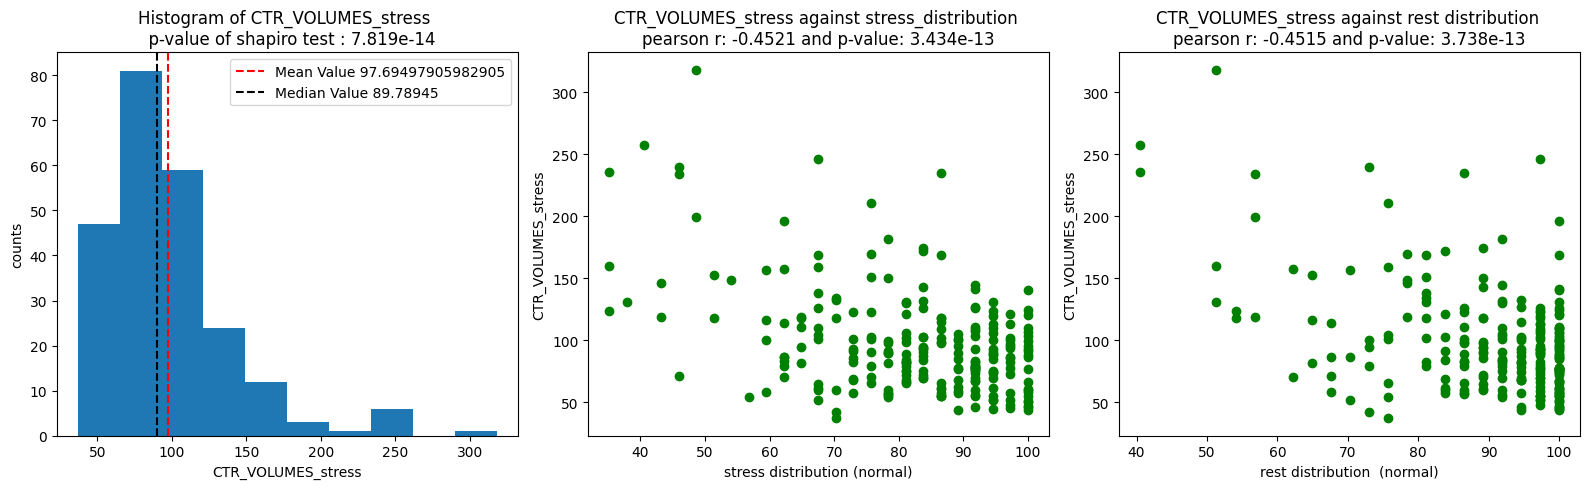

if p<0.05, we reject this is gaussian distributed
2.290312579346365e-13
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.39027996494882766 and p-value: 6.202506882945286e-10
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.39777913953250077 and p-value: 2.7055740122560957e-10


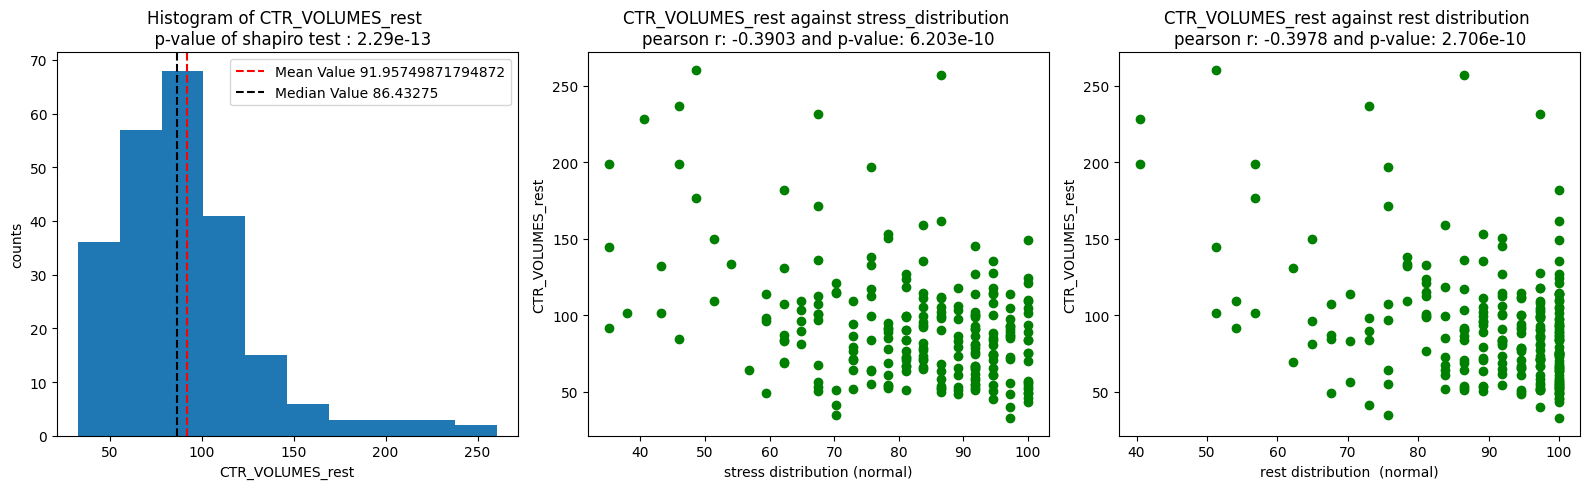

if p<0.05, we reject this is gaussian distributed
2.4139505566439685e-14
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.45288511833281114 and p-value: 3.1028292503194106e-13
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.45318286851241685 and p-value: 2.9811412615073964e-13


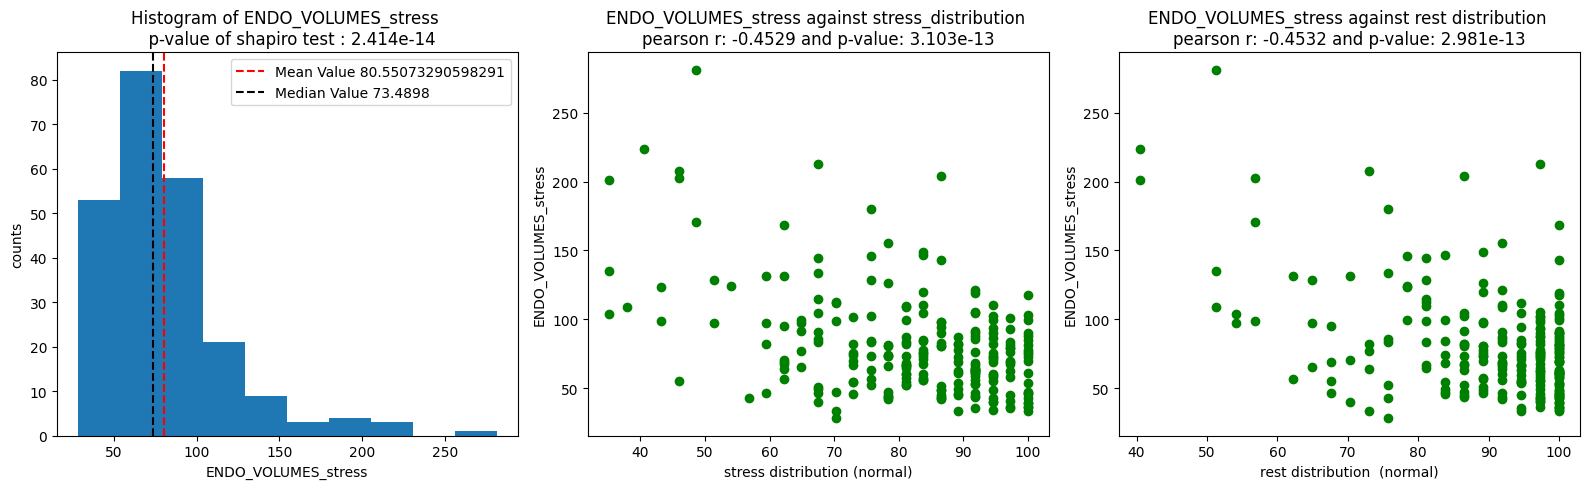

if p<0.05, we reject this is gaussian distributed
7.253040128132188e-14
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.39029387382719094 and p-value: 6.193089020285923e-10
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.39870002776828545 and p-value: 2.439992332220729e-10


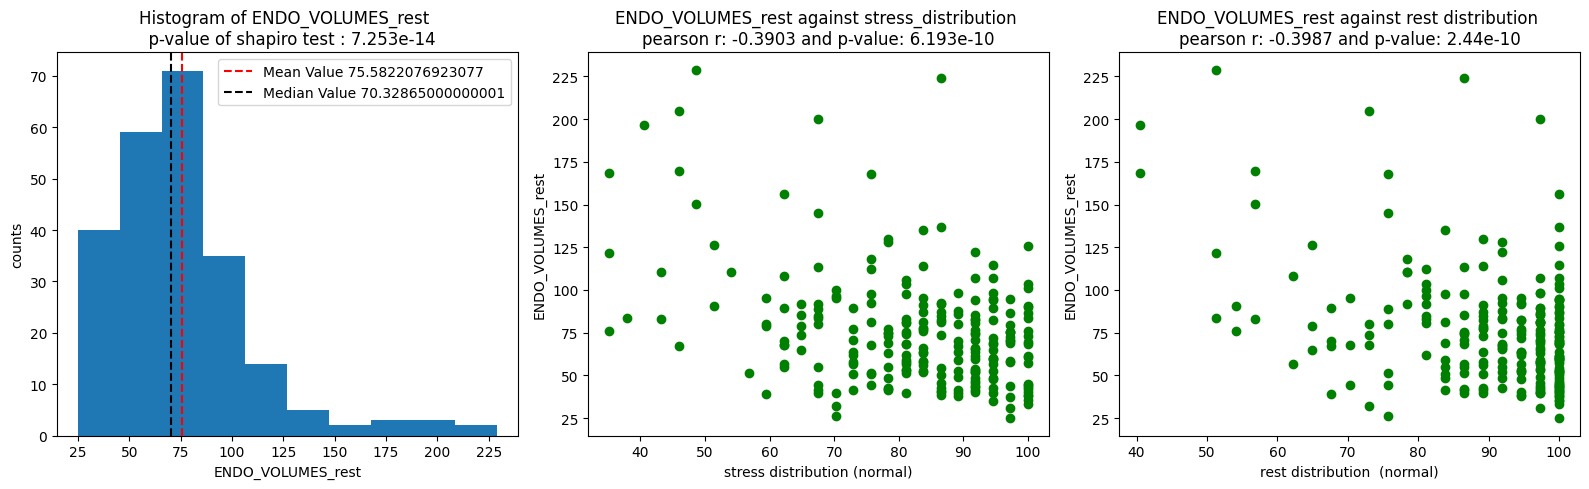

if p<0.05, we reject this is gaussian distributed
1.3509901464203722e-06
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: -0.2253091951721012 and p-value: 0.0005149193475652503
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: -0.17123195476023717 and p-value: 0.008671715360930733


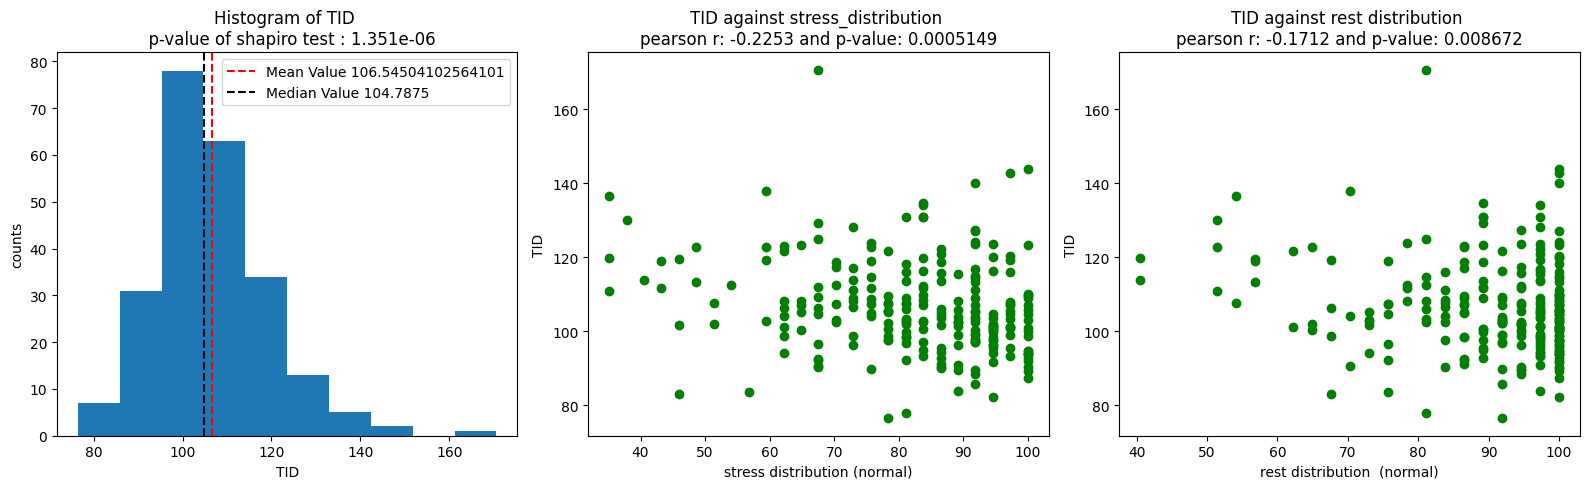

if p<0.05, we reject this is gaussian distributed
7.220450348732754e-10
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: 0.18461499639409362 and p-value: 0.004606457212189726
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: 0.08752314789849748 and p-value: 0.18212556545979566


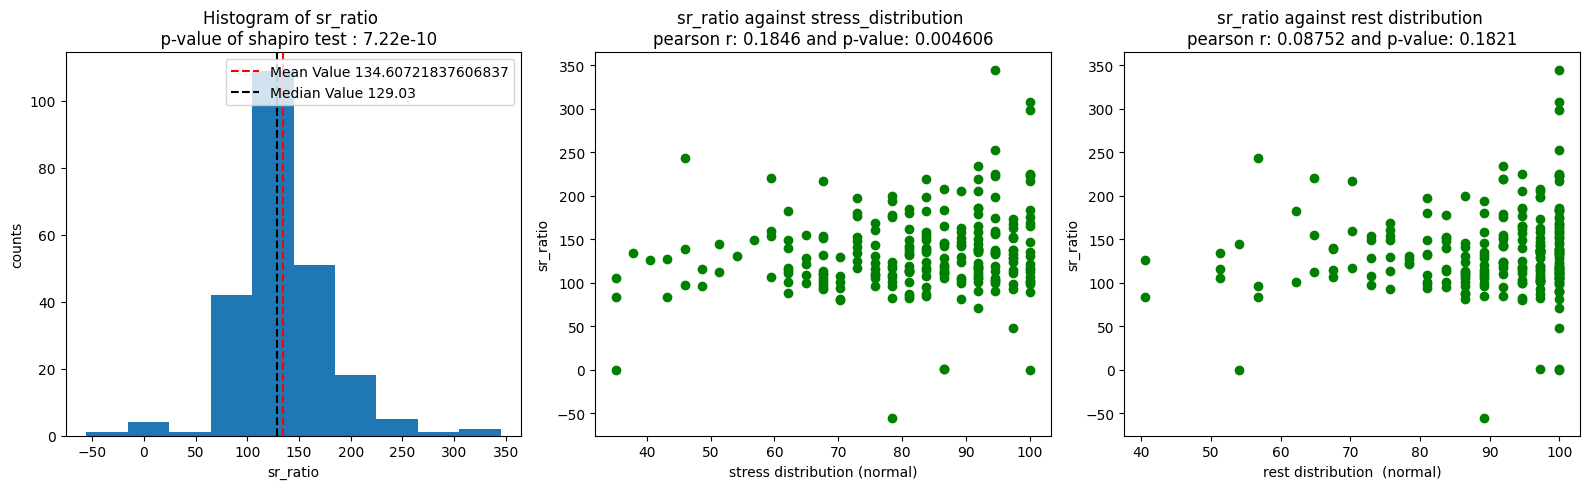

if p<0.05, we reject this is gaussian distributed
7.156349124404215e-11
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: 1.0 and p-value: 0.0
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: 0.8777420450992617 and p-value: 4.3724470399411897e-76


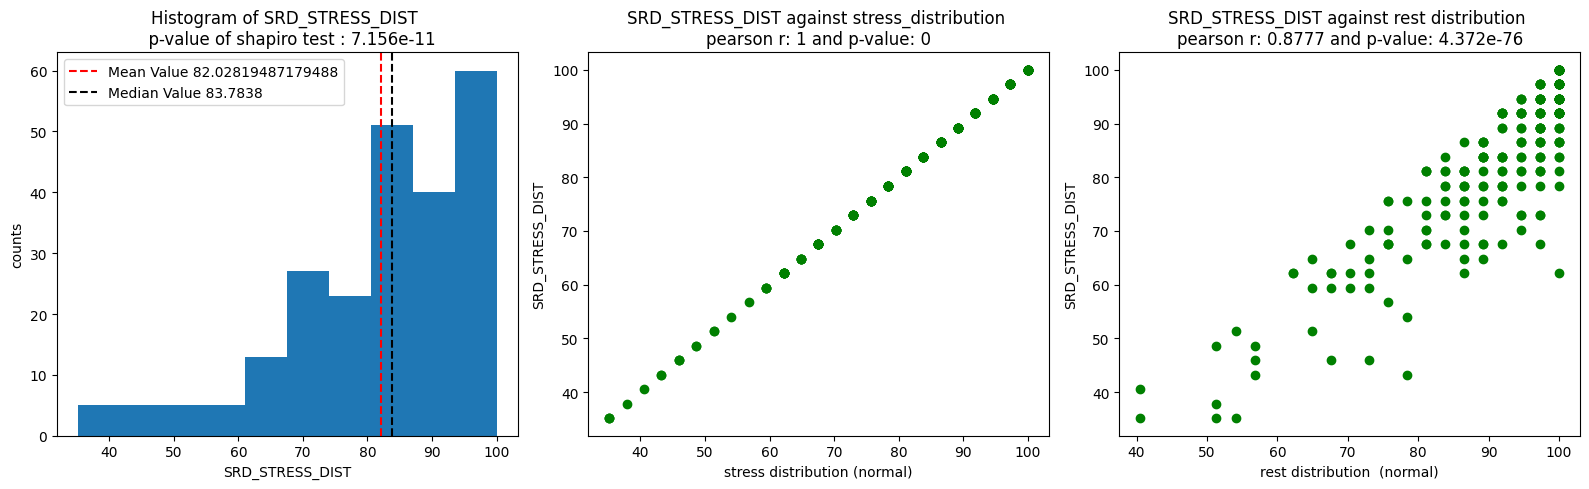

if p<0.05, we reject this is gaussian distributed
3.8440165017580415e-17
Pearson test  between normal stress distribution  (Confidence_level = 0.95) : 
pearson r: 0.8777420450992617 and p-value: 4.3724470399411897e-76
Pearson test  between normal rest distribution  (Confidence_level = 0.95) : 
pearson r: 0.9999999999999999 and p-value: 0.0


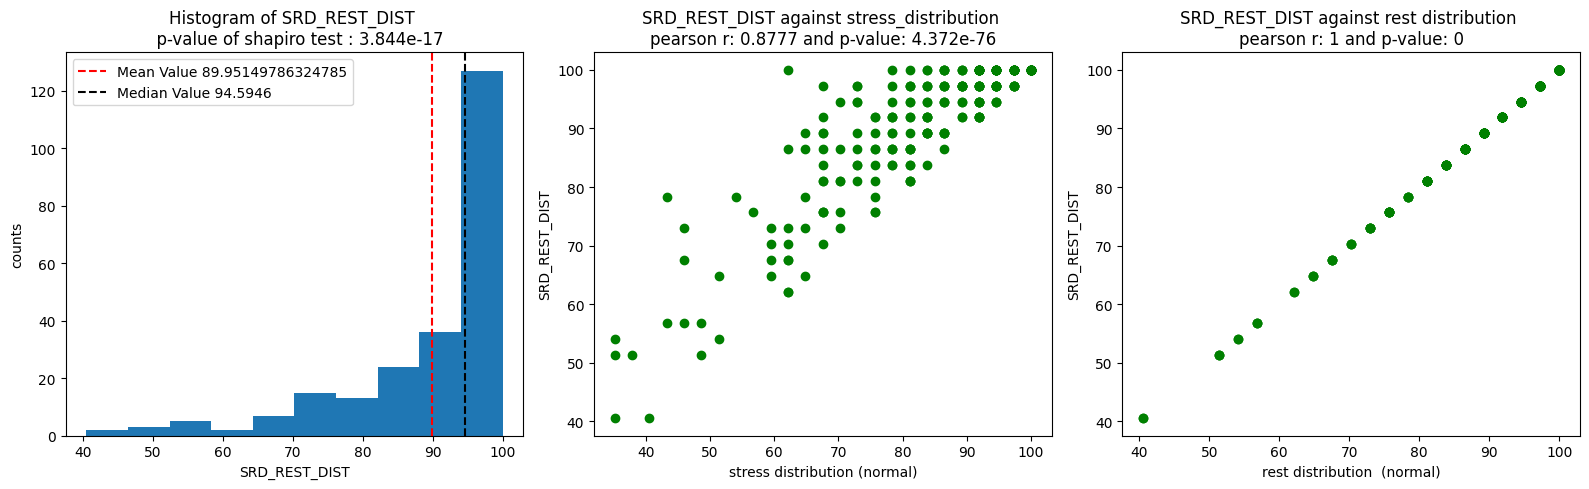

In [40]:
for i in range(pat_mat.shape[1]):
    plot(pat_mat[:,i],pat_mat[:,-2],pat_mat[:,-1],colume=colume[i])

In [ ]:
## CTR volume stress/rest
plot(pat_mat[:,0]/pat_mat[:,1],pat_mat[:,-2],pat_mat[:,-1],colume="CTR volume stress over rest")

In [ ]:
## CTR volume stress-rest
plot(pat_mat[:,0]-pat_mat[:,1],pat_mat[:,-2],pat_mat[:,-1],colume="CTR volume stress-rest")

In [ ]:
## Endo Volume stress/rest
plot(pat_mat[:,2]/pat_mat[:,3],pat_mat[:,-2],pat_mat[:,-1],colume="Endo Volume stress over rest")

In [ ]:
## Endo Volume stress-rest
plot(pat_mat[:,2]-pat_mat[:,3],pat_mat[:,-2],pat_mat[:,-1],colume="Endo Volume stress-rest")

In [61]:
pat_bin,pat_txt,pat_name=pair_bin_txt('DUMP')
arr5=ImageBin('DUMP'+'/'+pat_bin[0]).combine_5()

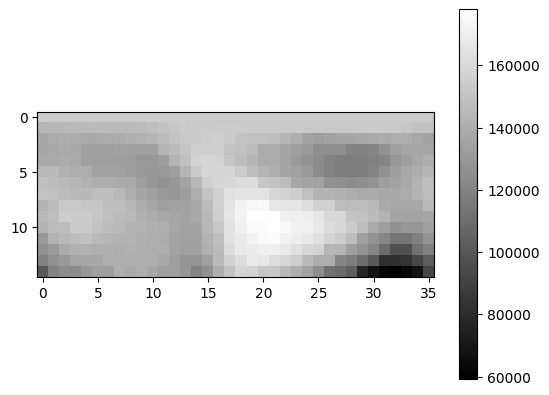

In [62]:
plt.figure()
plt.imshow(arr5[0,:,:],cmap='gray')
plt.colorbar()

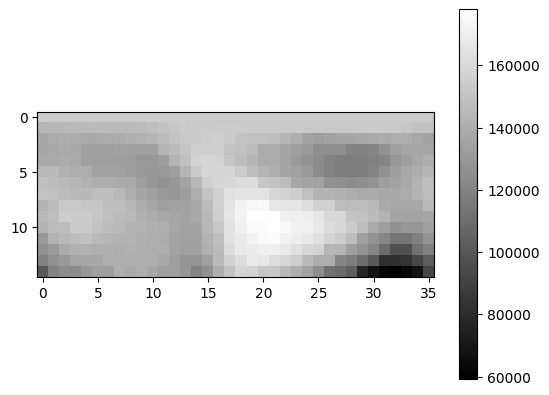

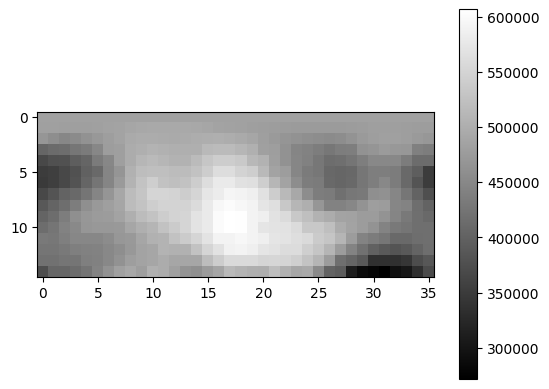

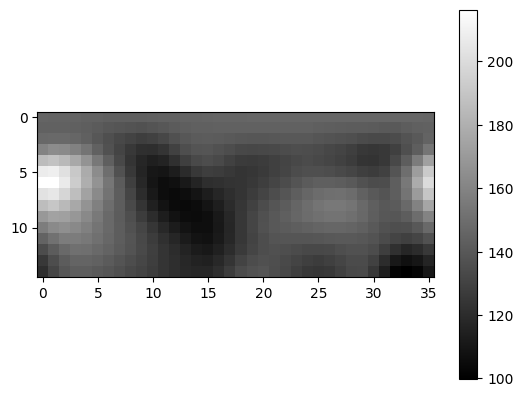

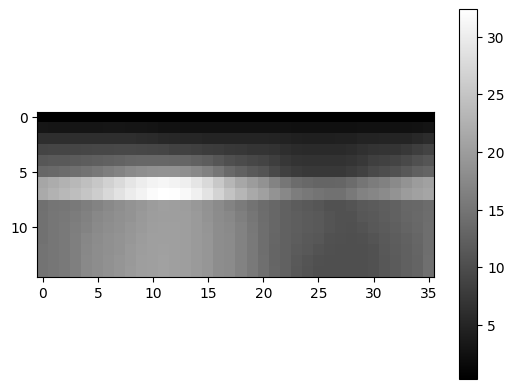

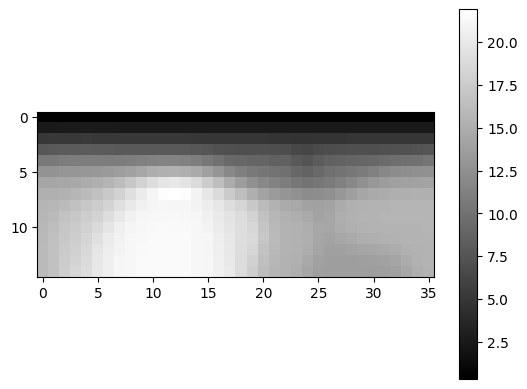

In [63]:
for i in range(5):
    plt.figure()
    plt.imshow(arr5[i,:,:],cmap='gray')
    plt.colorbar()